In [1]:
import pandas as pd

summary = pd.read_csv('news_summary.csv',
                      encoding='iso-8859-1')
raw = pd.read_csv('news_summary_more.csv',
                  encoding='iso-8859-1')

In [2]:
pre1 = raw.iloc[:, 0:2].copy()
pre2 = summary.iloc[:, 0:6].copy()

# To increase the intake of possible text values to build a reliable model
pre2['text'] = pre2['author'].str.cat(pre2['date'
        ].str.cat(pre2['read_more'].str.cat(pre2['text'
        ].str.cat(pre2['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')

pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'], pre2['headlines']],
                           ignore_index=True)

In [3]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):

    for row in column:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [4]:
processed_text = text_strip(pre['text'])
processed_summary = text_strip(pre['summary'])

In [5]:
from time import time
import spacy
import en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
# nlp = spacy.load('en', disable=['ner', 'parser']) 
# Process text as batches and yield Doc objects in order
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=5000)]

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5000)]

In [6]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [7]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [8]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

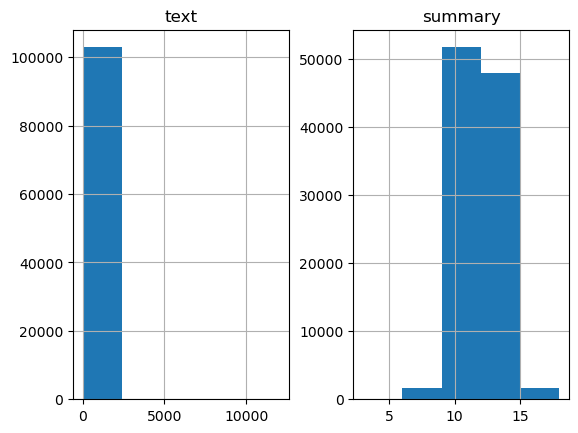

In [9]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [10]:
# Check how much % of text have 0-100 words
cnt = 0
for i in pre['cleaned_text']:
    if len(i.split()) <= 100:
        cnt = cnt + 1
print(cnt / len(pre['cleaned_text']))

0.9578389933440218


In [11]:
# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 100
max_summary_len = 15

In [39]:
# Select the Summaries and Text which fall below max length 

import numpy as np

cleaned_text = np.array(pre['cleaned_text'])
cleaned_summary= np.array(pre['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...


In [13]:
# Add sostok and eostok

post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...


In [14]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [15]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [16]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  62.625791318822664


In [17]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 29638


In [18]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 62.55667945587723
Size of vocabulary in Y = 12883


In [19]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [20]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
latent_dim = 256
embedding_dim = 150

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 150)  │  4,445,700 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 100,      │    416,768 │ embedding[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 100,      │    525,312 │ lstm[0][0]        │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 150) │  1,932,450 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 100,      │    525,312 │ lstm_1[0][0]      │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    416,768 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  3,310,931 │ lstm_3[0][0]      │
│ (TimeDistributed)   │ 12883)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,573,241 (44.15 MB)

 Trainable params: 11,573,241 (44.15 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [24]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 718s 1s/step - loss: 5.9591 - val_loss: 5.1191
Epoch 2/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 1057s 2s/step - loss: 5.1513 - val_loss: 5.0122
Epoch 3/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 929s 1s/step - loss: 5.0549 - val_loss: 4.9510
Epoch 4/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 884s 1s/step - loss: 4.9925 - val_loss: 4.9103
Epoch 5/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 814s 1s/step - loss: 4.9404 - val_loss: 4.8789
Epoch 6/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 1212s 2s/step - loss: 4.9045 - val_loss: 4.8430
Epoch 7/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 2612s 4s/step - loss: 4.8601 - val_loss: 4.7973
Epoch 8/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 2705s 4s/step - loss: 4.8164 - val_loss: 4.7558
Epoch 9/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 882s 1s/step - loss: 4.7626 - val_loss: 4.7109
Epoch 10/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 681s 985ms/step - loss: 4.7196 - val_loss: 4.6785
Epoch 11/50
692/692 ━━━━━━━━━━━━━━━━━━━━ 711s 1s/step - loss: 4.6704 - val_loss: 4.6288
Epoch 12/50
692/692 ━━━━━━━━━━━━━━

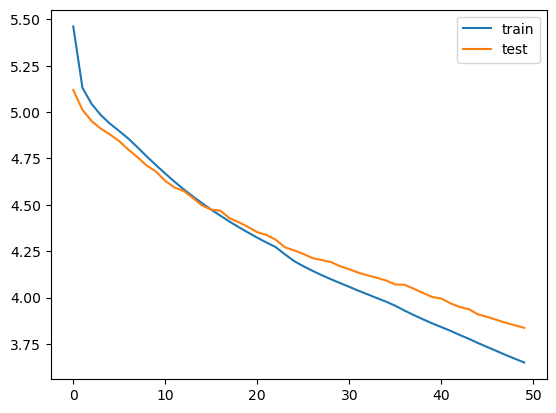

In [25]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [35]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [36]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [37]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [54]:
from rouge_score import rouge_scorer

f1_scores_rouge1 = []
f1_scores_rouge2 = []
f1_scores_rougeL = []
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for i in range(0, 200):
    print ('Review:', seq2text(x_tr[i]))
    og = seq2summary(y_tr[i]).split()
    print(' '.join(og[1:len(og)-1]))
    print ('Original summary:', ' '.join(og[1:len(og)-1]))
    generated = decode_sequence(x_tr[i].reshape(1, max_text_len)).split()
    
    print ('Predicted summary:', ' '.join(generated[1:len(generated)-1]))
    print ('\n')
    
    scores = scorer.score(' '.join(og[1:len(og)-1]), ' '.join(generated[1:len(generated)-1]))

    f1_scores_rouge1.append(scores['rouge1'].fmeasure)
    f1_scores_rouge2.append(scores['rouge2'].fmeasure)
    f1_scores_rougeL.append(scores['rougeL'].fmeasure)

Review: lok janshakti party president ram vilas paswan daughter asha has said she will contest elections against him from constituency if given ticket from lalu prasad yadav rjd she accused him of neglecting her and promoting his son chirag asha is paswan daughter from his first wife while chirag is his son from his second wife 
will contest against father ram vilas from daughter
Original summary: will contest against father ram vilas from daughter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: bjp lead

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: no one of the country of india pm modi


Review: sunny leone has shared post on instagram in which she has asked her fans to donate to crowdfunding page started by her to help prabhakar member of her staff who is battling kidney disease she added that only 20 of his kidneys are functioning his entire family depends on him for their survival sunny further wrote 
sunny asks fans to help staff member battling kidney disease
Original summary: sunny asks fans to help staff member battling kidney dis

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: paytm launches its first ever in india


Review: amid speculation of dmk joining the third front for the 2019 lok sabha elections the dmk has declared that it will continue its ties with the congress it said there has been no talk about the third front adding the dmk will support all the chief ministers who speak out for the cause of federal structure and autonomy for states 
no talk of third front will continue ties with cong dmk
Original summary: no talk of third front will continue ties with cong dmk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: nasa to launch its first ever in space


Review: actress anushka sharma while sharing pictures from the cleanliness drive she took part in at mumbai versova beach captioned it the pleasure felt in cleaning the beach is she added our country is our mother and to keep our country clean is our duty anushka recently joined swachh bharat abhiyan campaign on an invitation by pm modi 
pleasure felt in cleaning the beach anushka
Original summary: pleasure felt in cleaning the beach anushka
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted summary: india 1st indian to win india in 2018


Review: sports social engagement app rooter today announced it has raised ã¢ââ¹4 5 crore in pre series funding round from group of indian and foreign investors from venture catalysts investors khalid al anjali malhotra pranay and others participated in the funding founded in 2016 by piyush kumar and akshat goel rooter connects and engages sports fans during live matches 
sports social engagement app raises ã¢ââ¹4 5 crore
Original summary: sports social engagement app raises ã¢ââ¹4 5 crore
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: india to be world largest economy in india


Review: youtube rewind 2018 has become the second most disliked video on the platform with 8 1 million dislikes after justin leading with 9 7 million dislikes the video was released last week and is the most disliked video of the year it stars will smith and like marques brownlee and bhuvan bam and includes k pop and fortnite references 
youtube 2018 2nd most video after bieber
Original summary: youtube 2018 2nd most video after bieber
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: bjp leader who was bjp leader on bjp leader in law


Review: the maharashtra government has released ã¢ââ¹4 000 crore for farmers under the first phase of its farm loan waiver scheme chief minister devendra fadnavis announced on wednesday out of the funds released ã¢ââ¹3 200 crore is being spent on loan waivers while ã¢ââ¹800 crore is being given to encourage those who have regularly repaid their loans 
maha govt relea

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted summary: us to launch its first ever in first time in 2018


Review: a supporter of bjp leader bs yeddyurappa died of heart attack on saturday after he watched the 75 year old leader resign as karnataka chief minister ahead of the supreme court mandated floor test had distributed sweets among his friends and family after yeddyurappa swearing in ceremony last week yeddyurappa has condoled his death and is likely to visit his family

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted summary: china to invest in india for 1st time in 2018


Review: citing shortage of water in karnataka cm siddaramaiah has said it not possible to release water from the cauvery river this was in response to tamil nadu cm palaniswami request to him for 15 000 million cubic feet of water for his state notably the supreme court is expected to pronounce verdict on the river dispute in early february 
karnataka rejects tn request for release of cauvery water
Original summary: karnataka rejects tn request for release of cauvery water
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: startup raises 1 million in series funding


Review: bengaluru based online medical consultation startup has raised 7 2 million in series funding from bessemer venture partners and japanese investment firms corporation and dena networks it also saw participation from facebook investors anand and venky founded in 2013 the startup offers an app to connect doctors with patients in real time 
healthcare startup raises 7 2 mn in series a
Original summary: healthcare startup raises 7 2 mn in series a
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: bjp leader who won be in ayodhya if it cong leader


Review: the maharashtra legislative assembly on friday passed bill that seeks to prevent attacks on journalists and media houses introduced by chief minister devendra fadnavis the bill was passed without discussion in the absence of opposition members in the lower house police officer not below the rank of deputy superintendent of police shall investigate any under this

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted summary: delhi hc orders ban on sale of liquor in delhi


Review: facebook co founder and ceo mark zuckerberg on tuesday announced that his company will be building its ninth data center in nebraska us zuckerberg added that the data center will be powered by 100 renewable energy and will create thousands of jobs in the community over the next few years 
facebook data center to be built in
Original summary: facebook data center to be built in
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: kohli has been the most followed kohli on kohli


Review: a two year old boy was attacked and killed by leopard while he was out for walk with his family on saturday in mumbai the boy was grabbed and taken away by the leopard while the elders were walking ahead officials said he was brought to hospital where doctors declared him dead and said he died of blood loss 
leopard kills 2 year old boy on walk with family in mumbai
Original summary: leopard kills 2 year old boy on walk with family in mu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: i am not my life in wood film on film fest


Review: nushrat bharucha who has starred in luv ranjan four films including sonu ke titu ki sweety has tweeted an open letter in support of luv with caption this is my story stand by luv sir in the post nushrat has shared her experience of working with luv claiming that the sexual harassment allegations against luv are false 
i stand by luv ranjan nushrat says accusations on hi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted summary: india 1st indian to win world cup in 2018


Review: a panel suggested hiking the salaries of lower court judges by 30 as an interim relief statement issued on monday read an interim report recommended hike for nearly 20 000 judges whose salaries were last increased in 2010 the move is also seen as an incentive for lawyers to join lower judiciary which faces 28 vacancies 
panel suggests 30 interim hike in lower court judges pay
Original summary: panel suggests 30 interim hike in lower court judges pay
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: man arrested for raping woman in delhi


Review: a pilot on sunday landed his helicopter near mcdonald outlet in sydney australia to grab cheeseburger during an interview after his video went viral the pilot said now and then we do that sort of stuff offering to deliver for the interviewer meanwhile authorities said such landings are legal if the pilot has permission from the landowner 
pilot lands helicopter near mcdonald to grab
Original summary: pilot lands helicopter near mcdonald to grab
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted summary: sc asks centre for not paying for women in delhi


Review: the delhi high court has said that the centre cannot hold and retain the original documents of doctors trained at army run colleges for refusing to serve as short service commission officers the court added that the centre can recover an amount for the violation of the bond signed by the students but cannot keep original documents submitted by them 
army college doctors degrees can be held for not serving hc
Original summary: army college doctors degrees can be held for not serving hc
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted summary: ex aus captain to be named after kohli


Review: as many as 100 children were taken ill on wednesday after eating biscuits at government run residential school in uttar pradesh district the children were rushed to hospital after they complained of nausea and stomach ache around 45 children are in serious condition while the rest are kept under observation senior official said 
100 children fall sick in govt run residential school in up
Original summary: 100 children fall sick in govt run residential school in up
1/1 ━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: bjp leader who was the bjp leader on ram mandir


Review: actor benedict cumberbatch who played the lead role in 2016 superhero film doctor strange has said sachin tendulkar would fit the role as he is quite extraordinary cumberbatch revealed this to ex australian pacer brett lee during press tour of avengers infinity war in singapore cumberbatch further revealed he loved playing cricket and graham was his hero when growing up 
tendulkar could play doctor st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: scientists discover new year old theory


Review: delhi chief minister arvind kejriwal on thursday said aap will contest all the 13 lok sabha seats in punjab without entering into an alliance kejriwal who was in bathinda for an aap mla wedding also accused cm amarinder singh of making tall promises and not fulfilling them kejriwal said he spoke lies and now people of punjab are fed up 
aap to contest all 13 punjab ls seats no alliance likely
Original summary: aap to contest all 13 punjab ls seats no alliance likely
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: india to invest in india for 1st time in 2018


Review: indian american sikh businessman harry singh sidhu has been elected as the mayor of the anaheim city in california us sidhu moved to the us along with his parents in 1974 and has previously served as member of the anaheim city council he will be the first sikh mayor of anaheim 
indian american elected mayor of us city
Original summary: indian american elected mayor of us city
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: pm modi is not to be in india rahul gandhi


Review: the madras high court on wednesday ordered an interim stay on the national eligibility cum entrance test neet 2017 results till june this comes after petition called for the cancellation of the exam as different sets of question papers were used in different parts of the country the petitioner also claimed that the tamil question paper was easier 
madras hc puts neet 2017 results on hold till june 7
Origin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted summary: bjp leader booked for raping minor girl in up


Review: india sixth largest telecom operator aircel on wednesday filed for bankruptcy at the national company law tribunal nclt claiming that it has debt of ã¢ââ¹15 500 crore this comes after the krishnan owned malaysian parent maxis communications refused to infuse more funds into aircel notably aircel proposed merger with anil ambani reliance communications had failed last year 
india sixth largest telco aircel files for bankruptcy
Original summary: india sixth largest telco aircel files for bankruptcy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━

In [62]:
average_f1_rouge1 = sum(f1_scores_rouge1) / len(f1_scores_rouge1)
average_f1_rouge2 = sum(f1_scores_rouge2) / len(f1_scores_rouge2)
average_f1_rougeL = sum(f1_scores_rougeL) / len(f1_scores_rougeL)

print("Average F1 Score for ROUGE-1:", average_f1_rouge1)
print("Average F1 Score for ROUGE-2:", average_f1_rouge2)
print("Average F1 Score for ROUGE-L:", average_f1_rougeL)

Average F1 Score for ROUGE-1: 0.1552601970799574
Average F1 Score for ROUGE-2: 0.03282952539376688
Average F1 Score for ROUGE-L: 0.14296784976439023


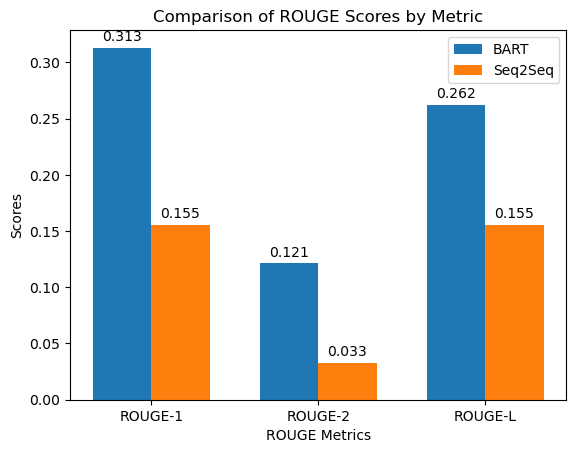

In [63]:
import matplotlib.pyplot as plt

# Data for BART and Seq2Seq models' ROUGE scores
models = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
bart_scores = [0.3130034028688957, 0.12115269642142497, 0.26217923070635807]
seq2seq_scores = [0.1552601970799574, 0.03282952539376688, 0.1552601970799574]

# Creating the bar chart
x = range(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, bart_scores, width, label='BART')
rects2 = ax.bar([p + width for p in x], seq2seq_scores, width, label='Seq2Seq')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('ROUGE Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of ROUGE Scores by Metric')
ax.set_xticks([p + width/2 for p in x])
ax.set_xticklabels(models)
ax.legend()

# Function to add labels on the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function to add labels
autolabel(rects1)
autolabel(rects2)

plt.show()
